In [1]:
from IPython.display import Image, display


 Displaying: dog.jpg


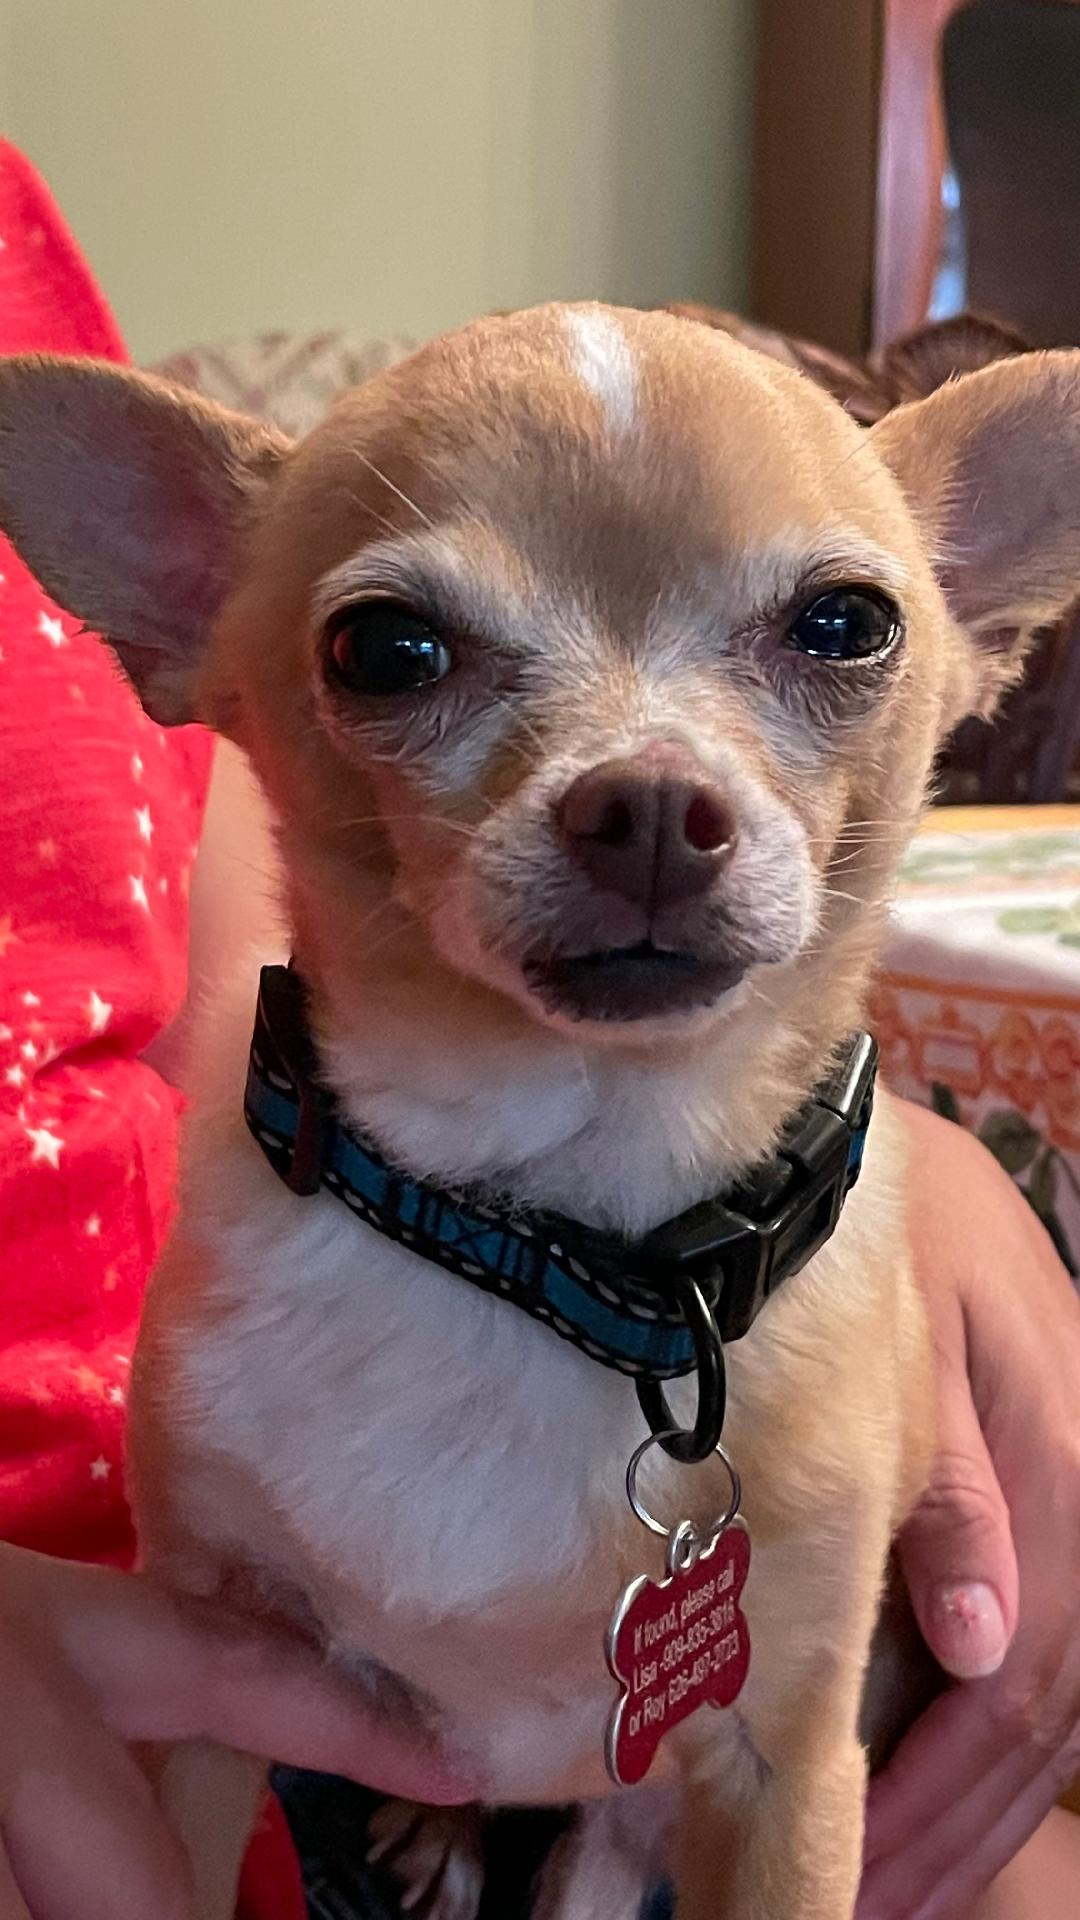


 Displaying: roses.jpg


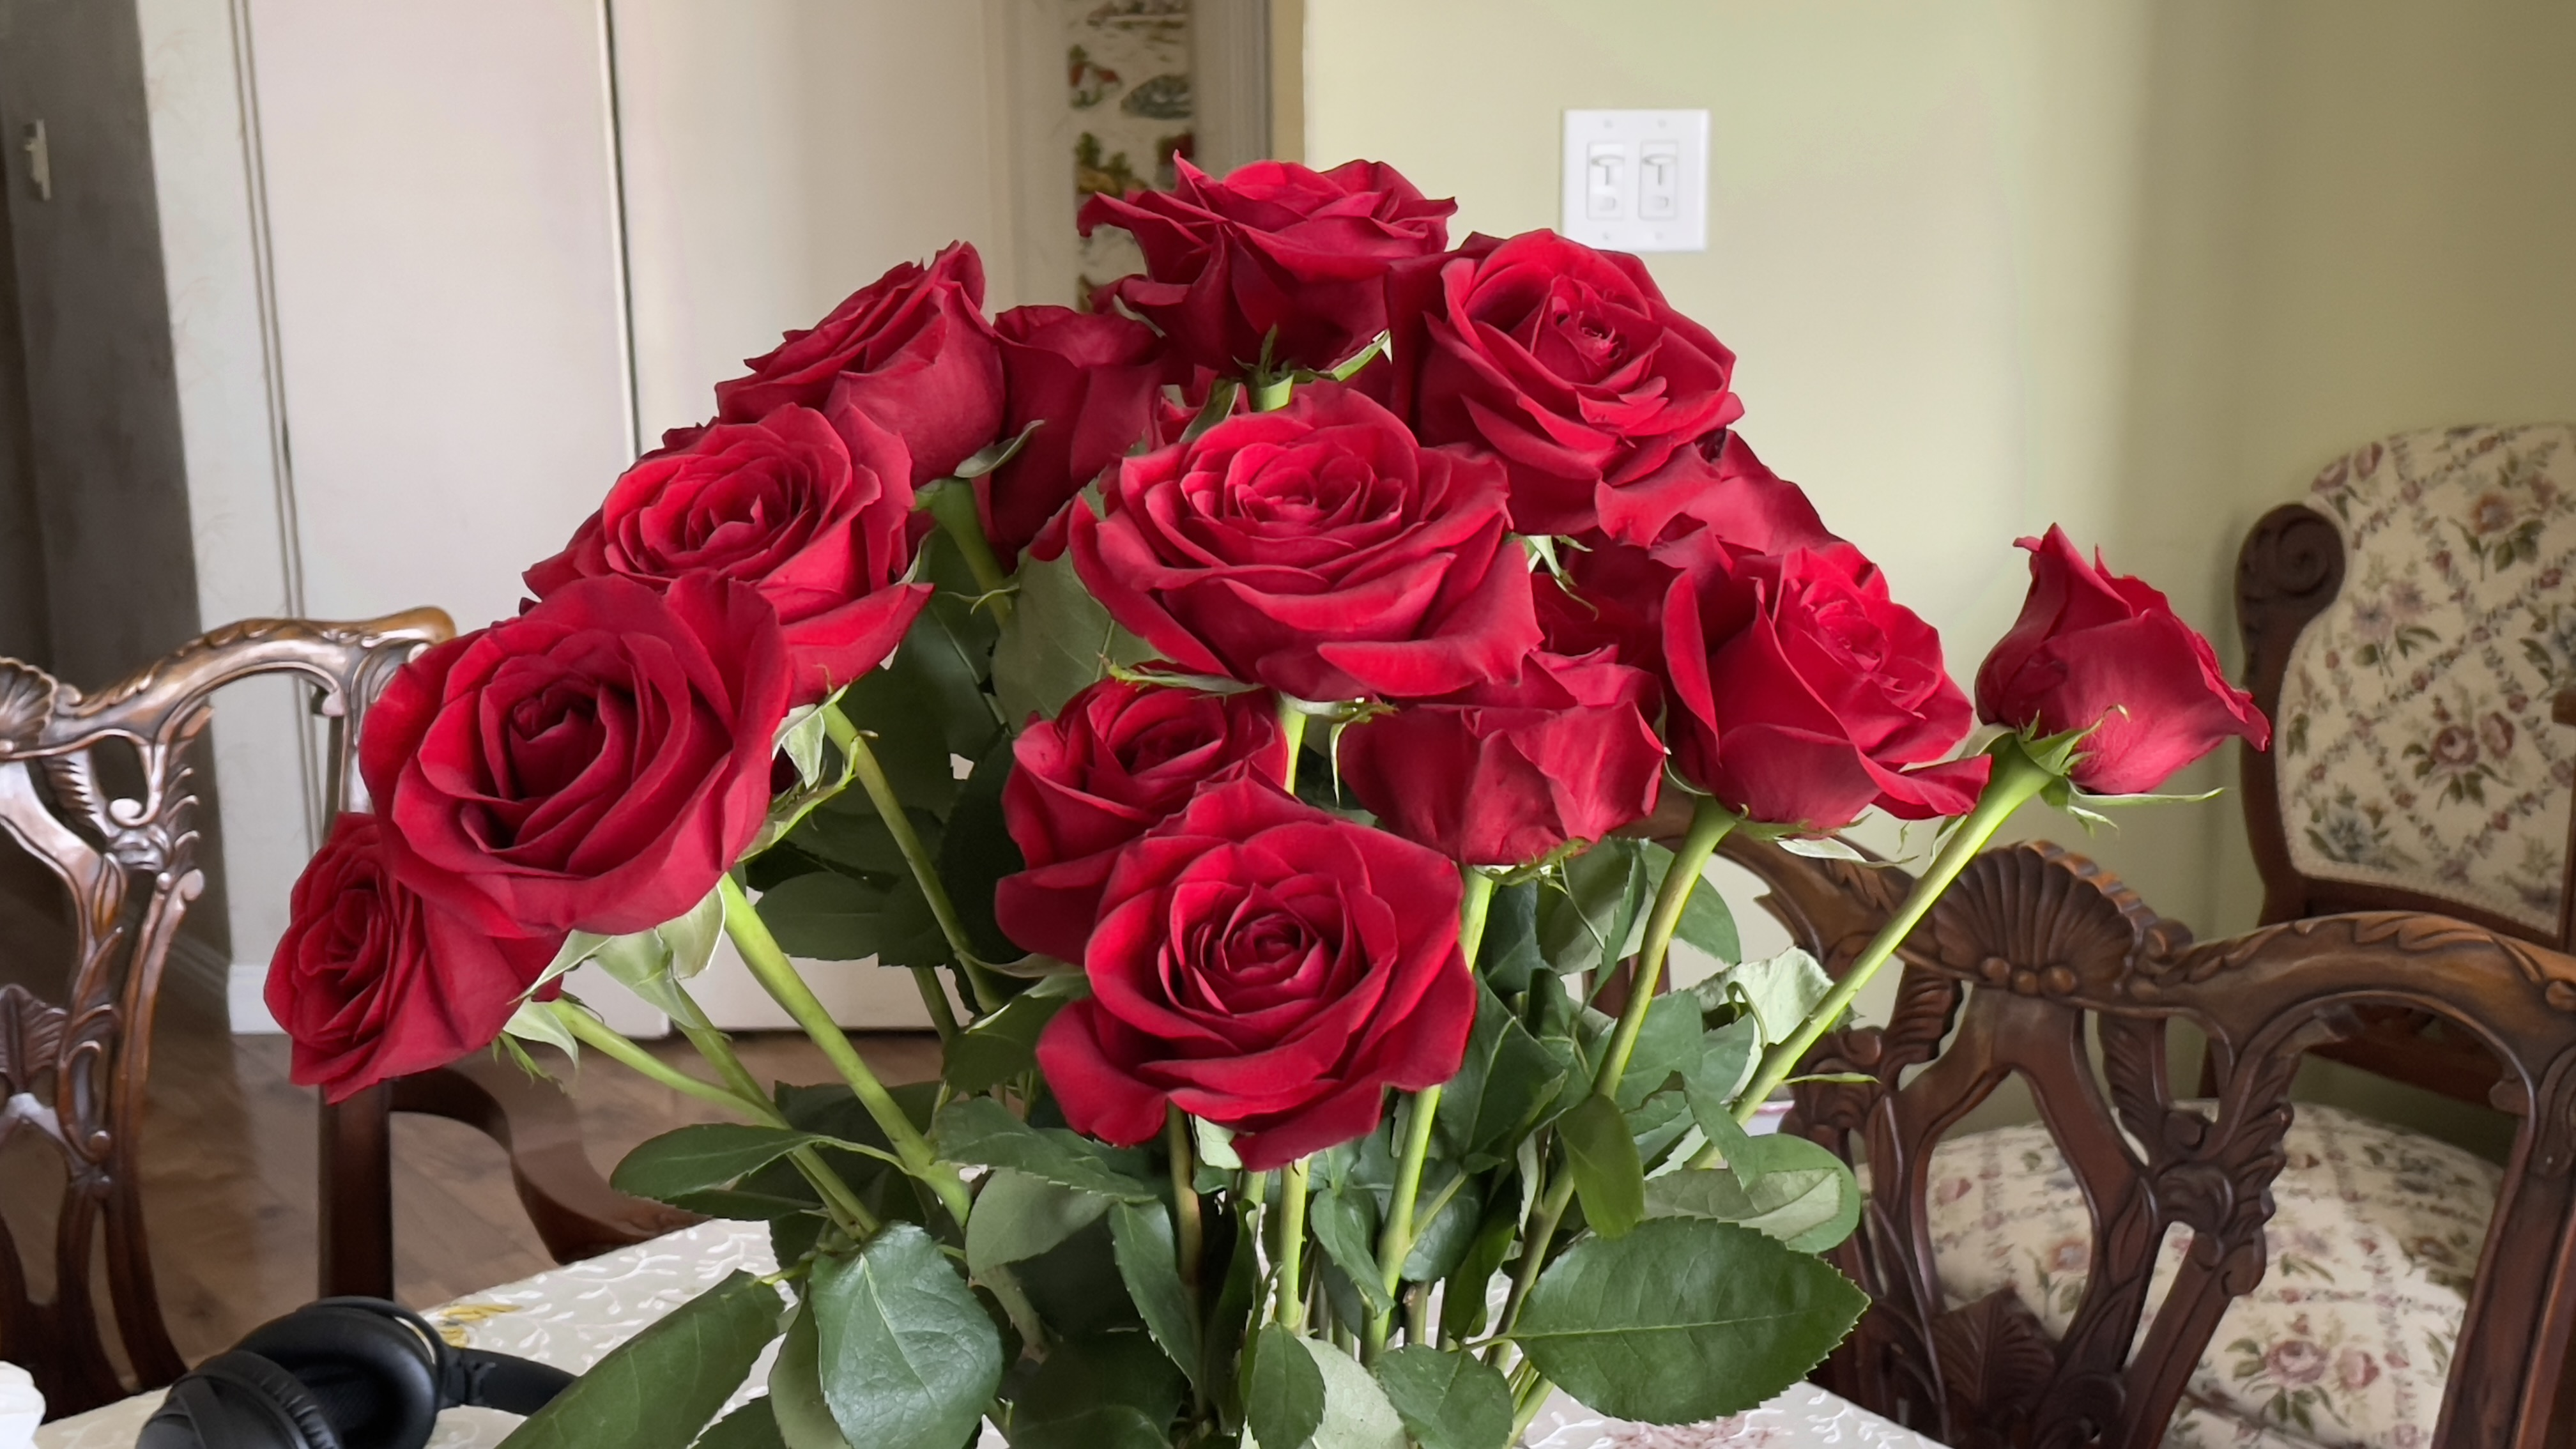


 Displaying: car.jpg


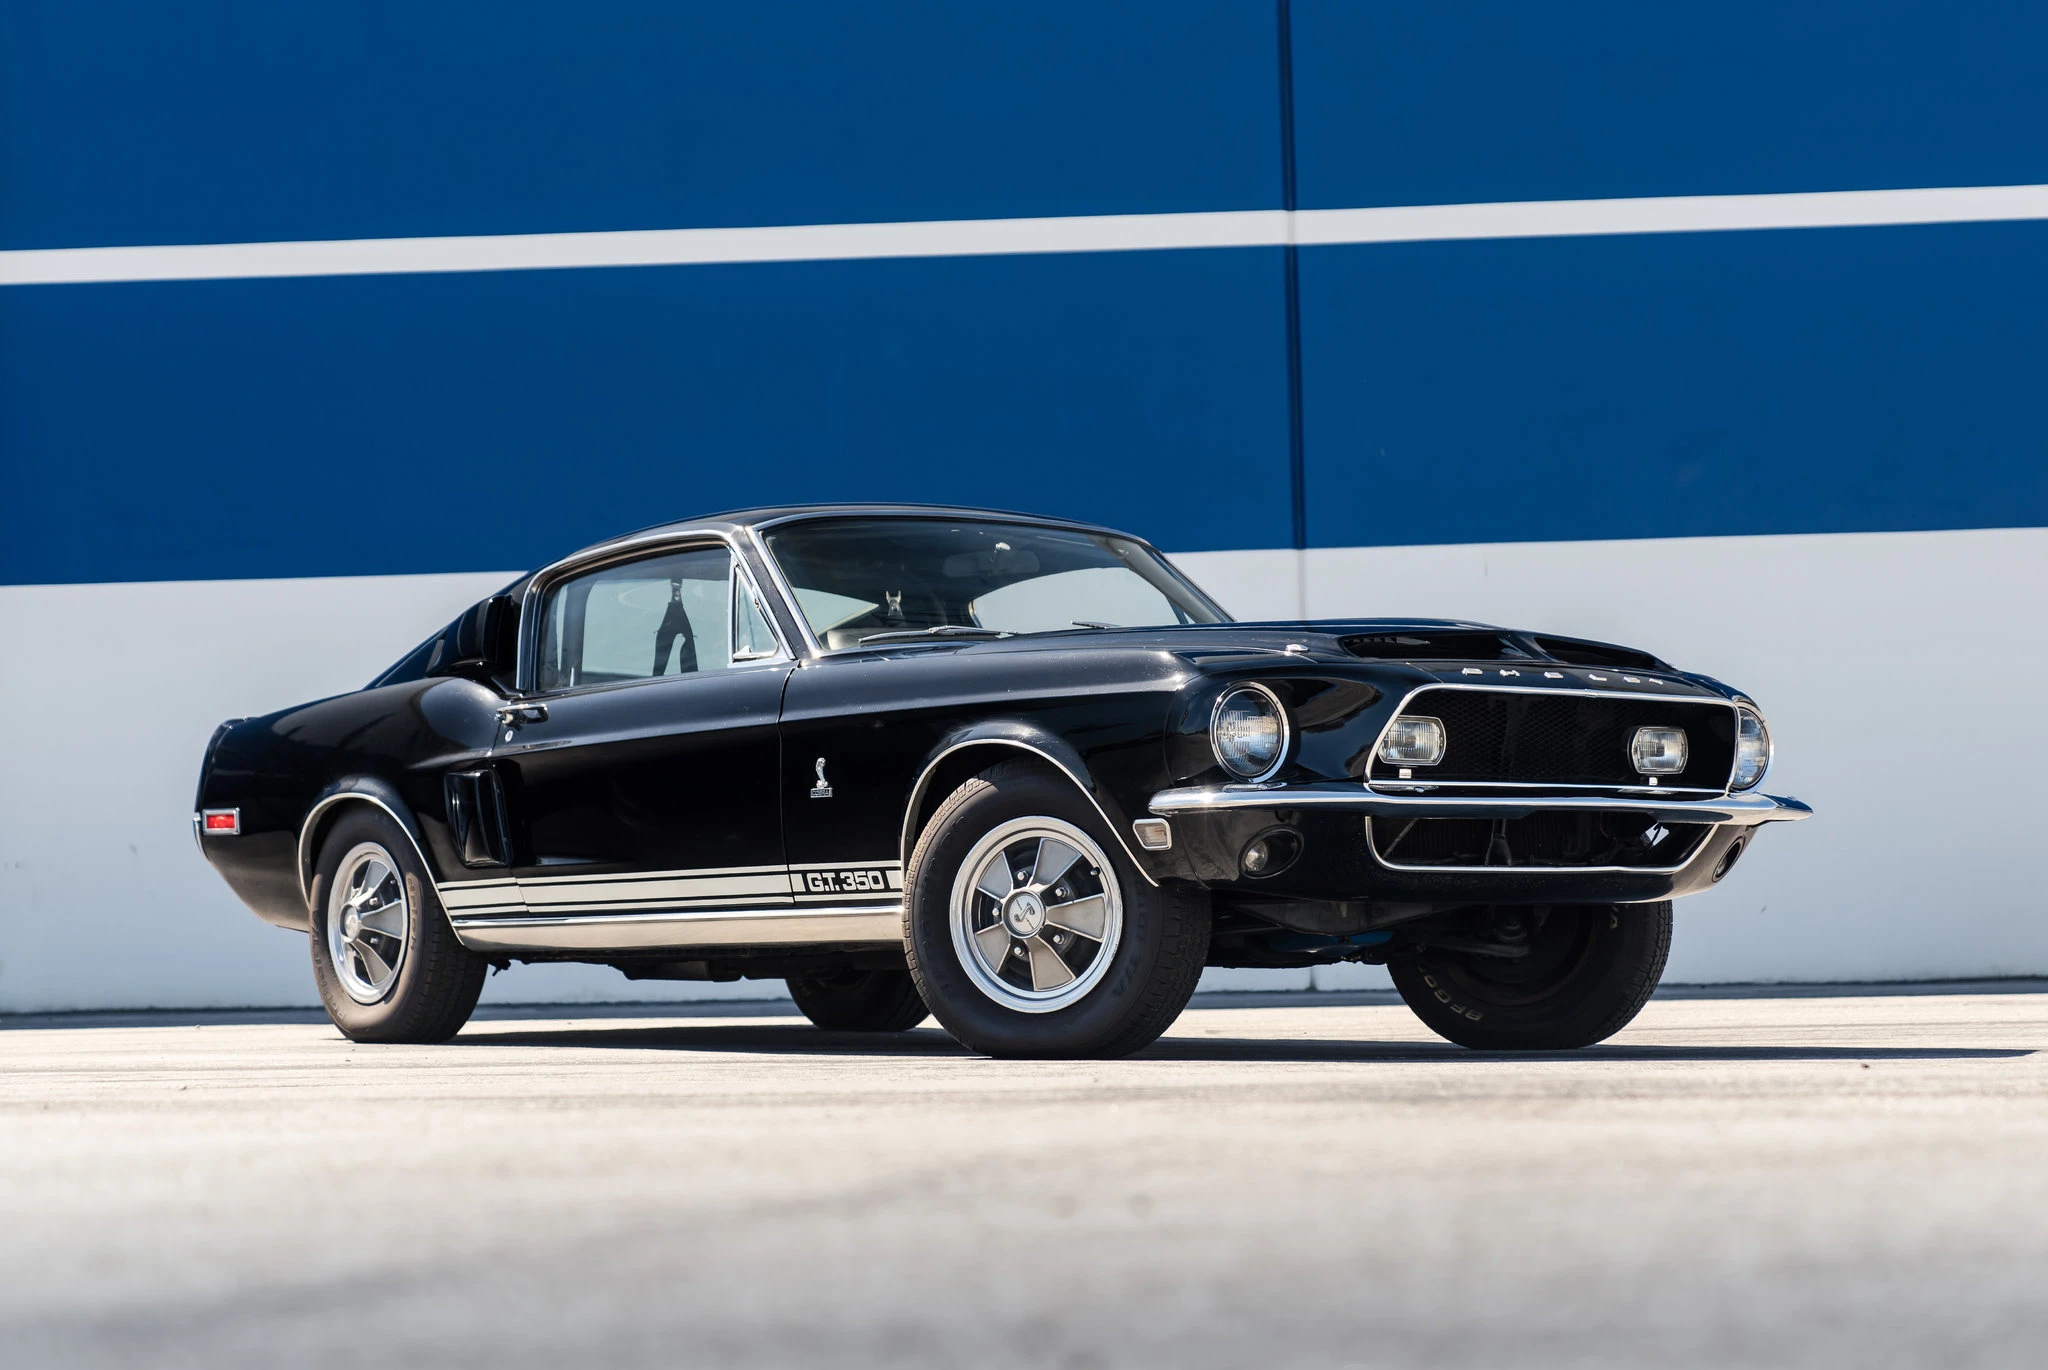


 Displaying: rocket.jpg


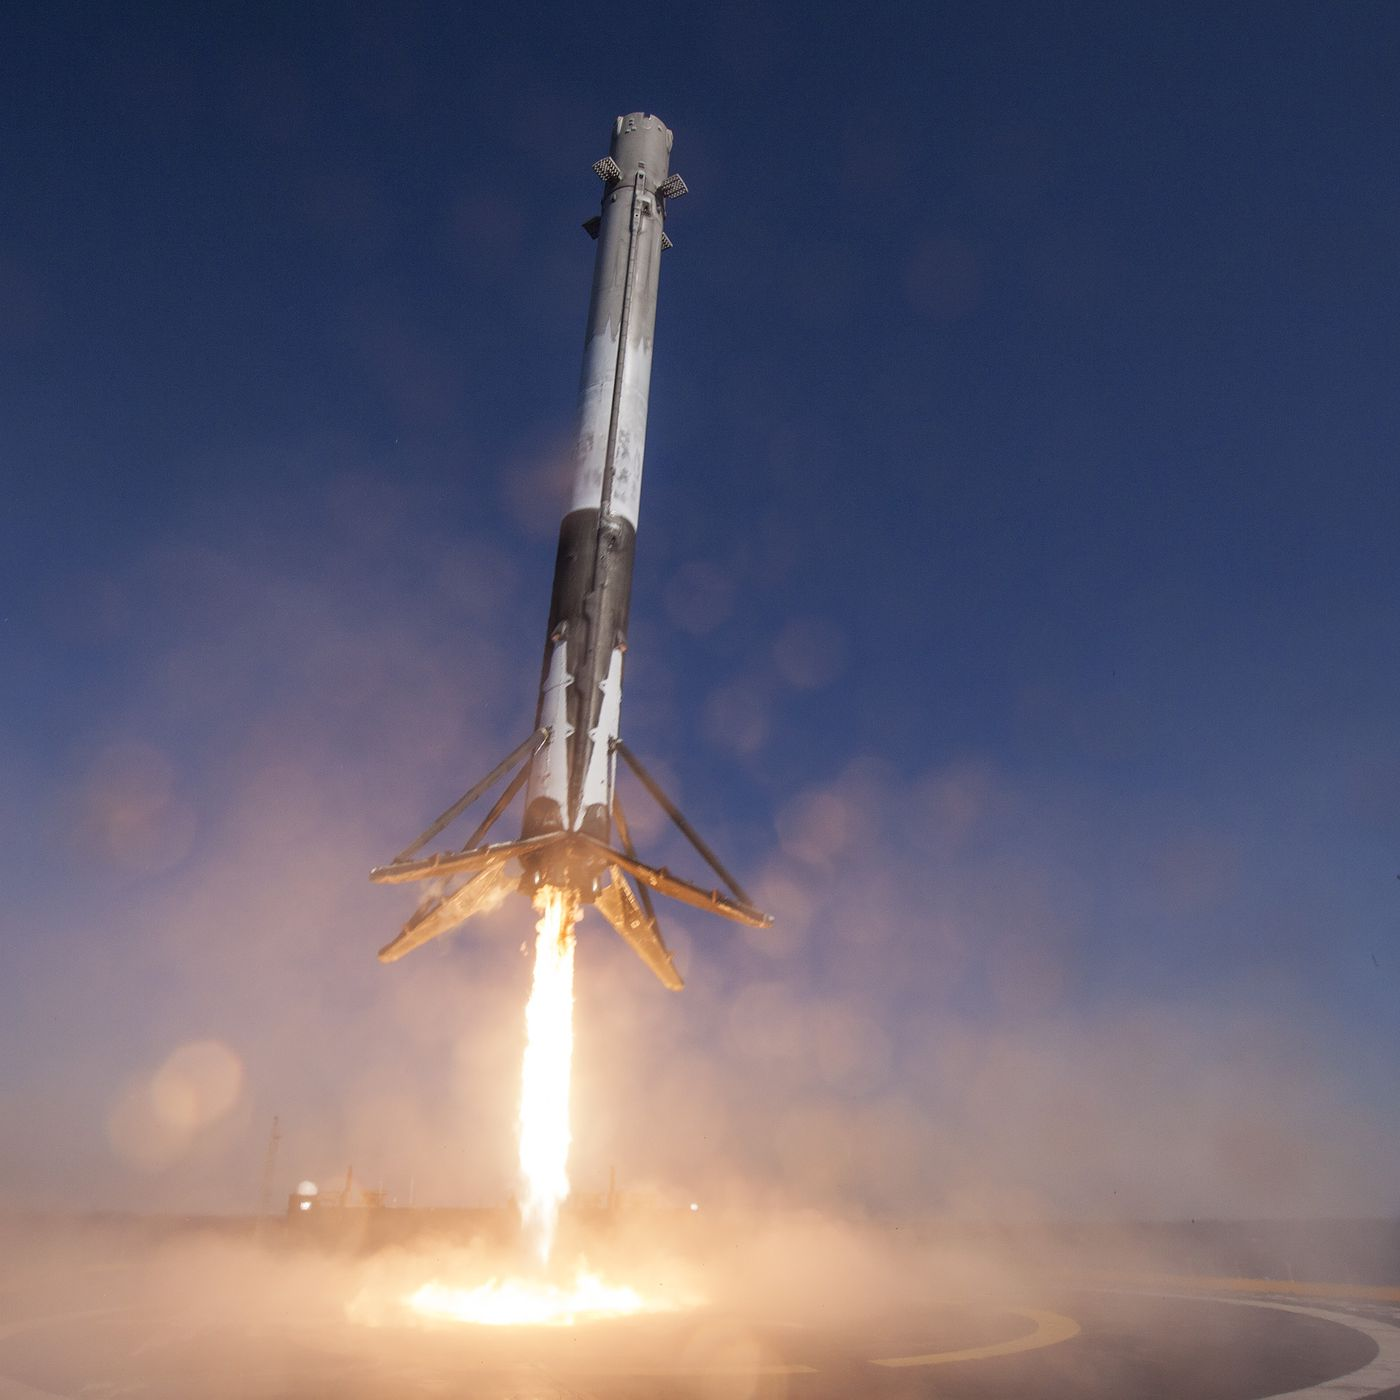


 Displaying: steak.jpg


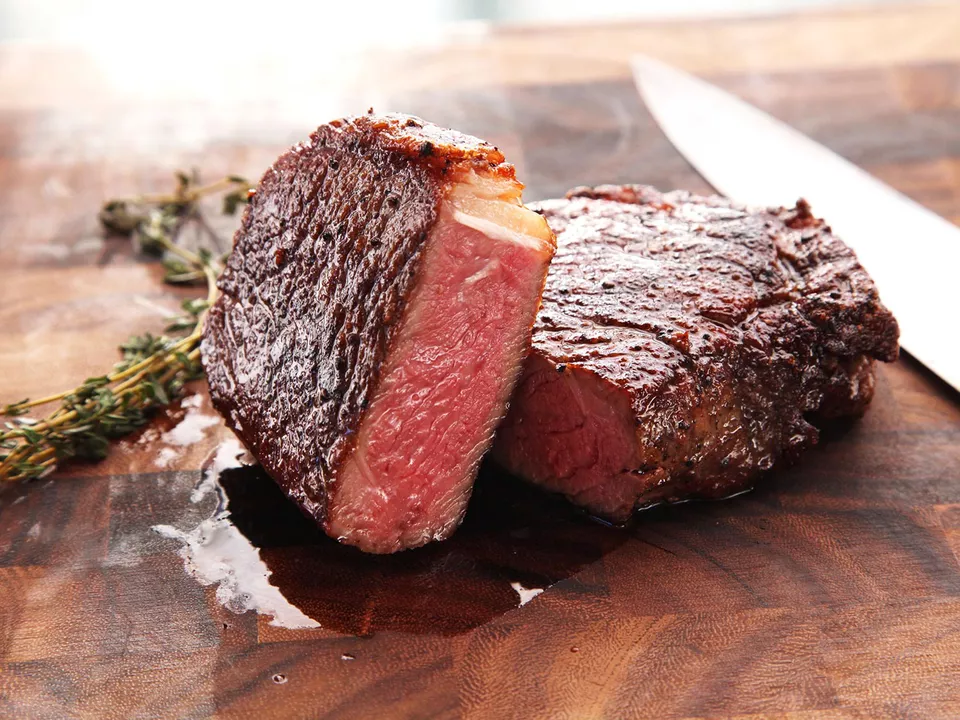

In [2]:
#Observer images we want to load
images = [
    'dog.jpg',
    'roses.jpg',
    'car.jpg',
    'rocket.jpg',
    'steak.jpg',
]

for image in images:
    print(f"\n Displaying: {image}")
    display(Image(filename=f"images/{image}"))

# Create Model Function

In [3]:
# Create directory to store the results of our image
import os

dir_name = 'processed_images'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [4]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

2021-07-27 17:52:47.691916: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-07-27 17:52:47.691933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def detect_and_identify(filename, model='vgg19', confidence=0.5):
    # Load images stored in the /images directory
    img_filepath = f'images/{filename}'
    
    #Convert image into numpy array
    img = cv2.imread(img_filepath)
    
    # Use cvlib to use object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    #Print the file name
    print(f'==================\nImage processed: {filename}\n')
    
    #Print detected object
    for l, c in zip(label, conf):
        print(f"Detect object: {l} has a confidence level of {c}\n")
        
    #Create new image with the detection box
    processed_image = draw_bbox(img, bbox, label, conf)

    #Save processed images in processed_images directory
    cv2.imwrite(f'processed_images/{filename}', processed_image)
    
    #Show new images with boxes
    display(Image(f'processed_images/{filename}'))

Image processed: dog.jpg

Detect object: dog has a confidence level of 0.9953513741493225



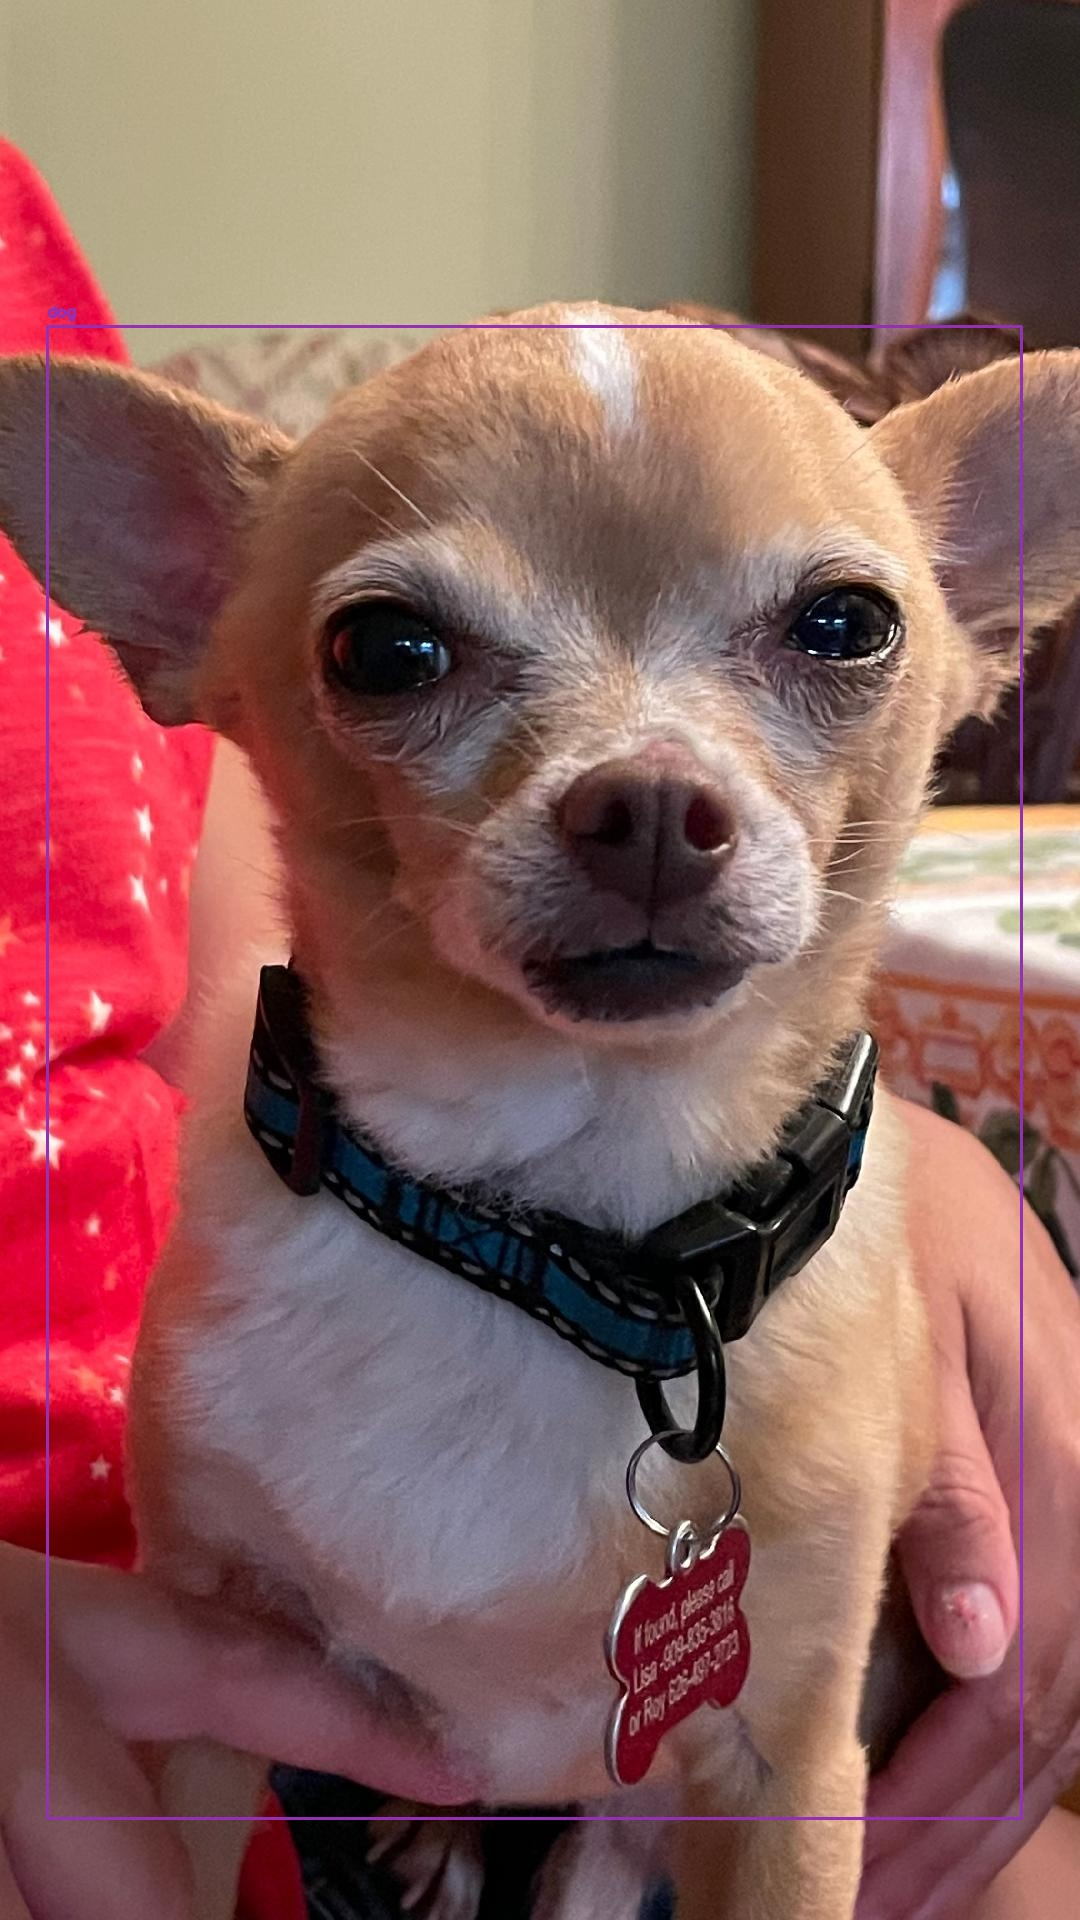

Image processed: roses.jpg

Detect object: chair has a confidence level of 0.6949930787086487

Detect object: chair has a confidence level of 0.5436860918998718

Detect object: chair has a confidence level of 0.5072088837623596



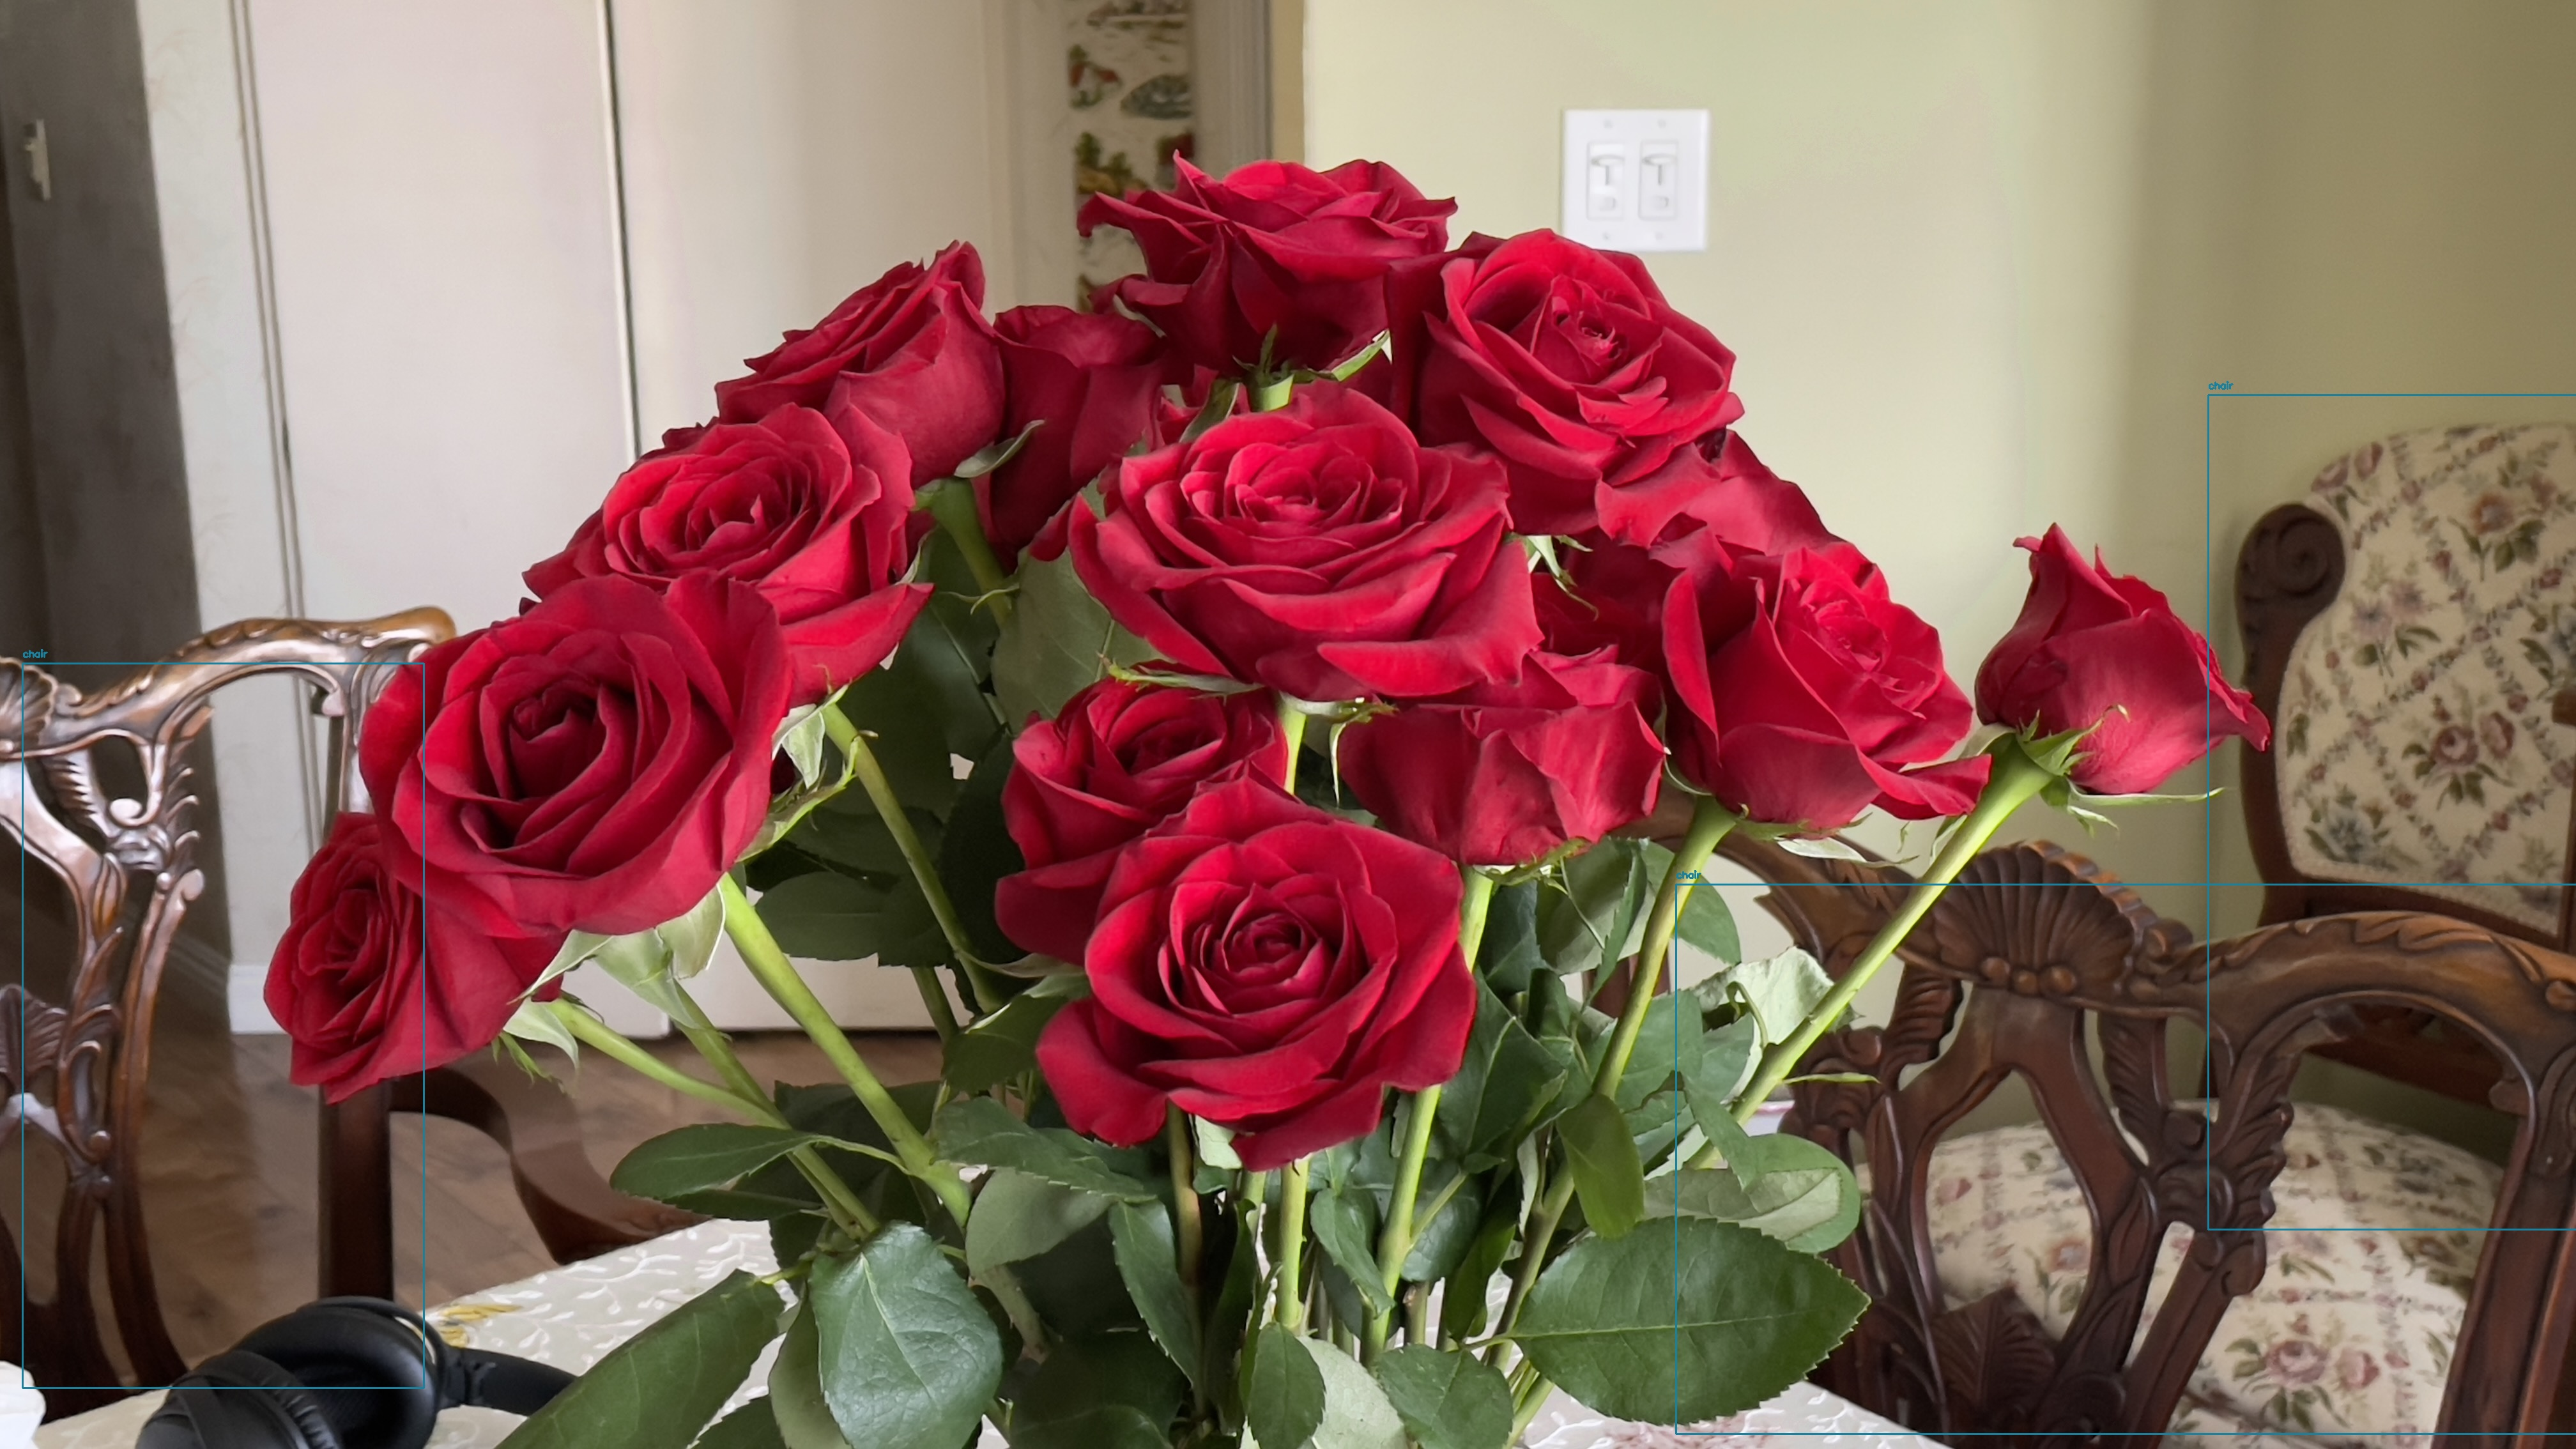

Image processed: car.jpg

Detect object: car has a confidence level of 0.8579635620117188



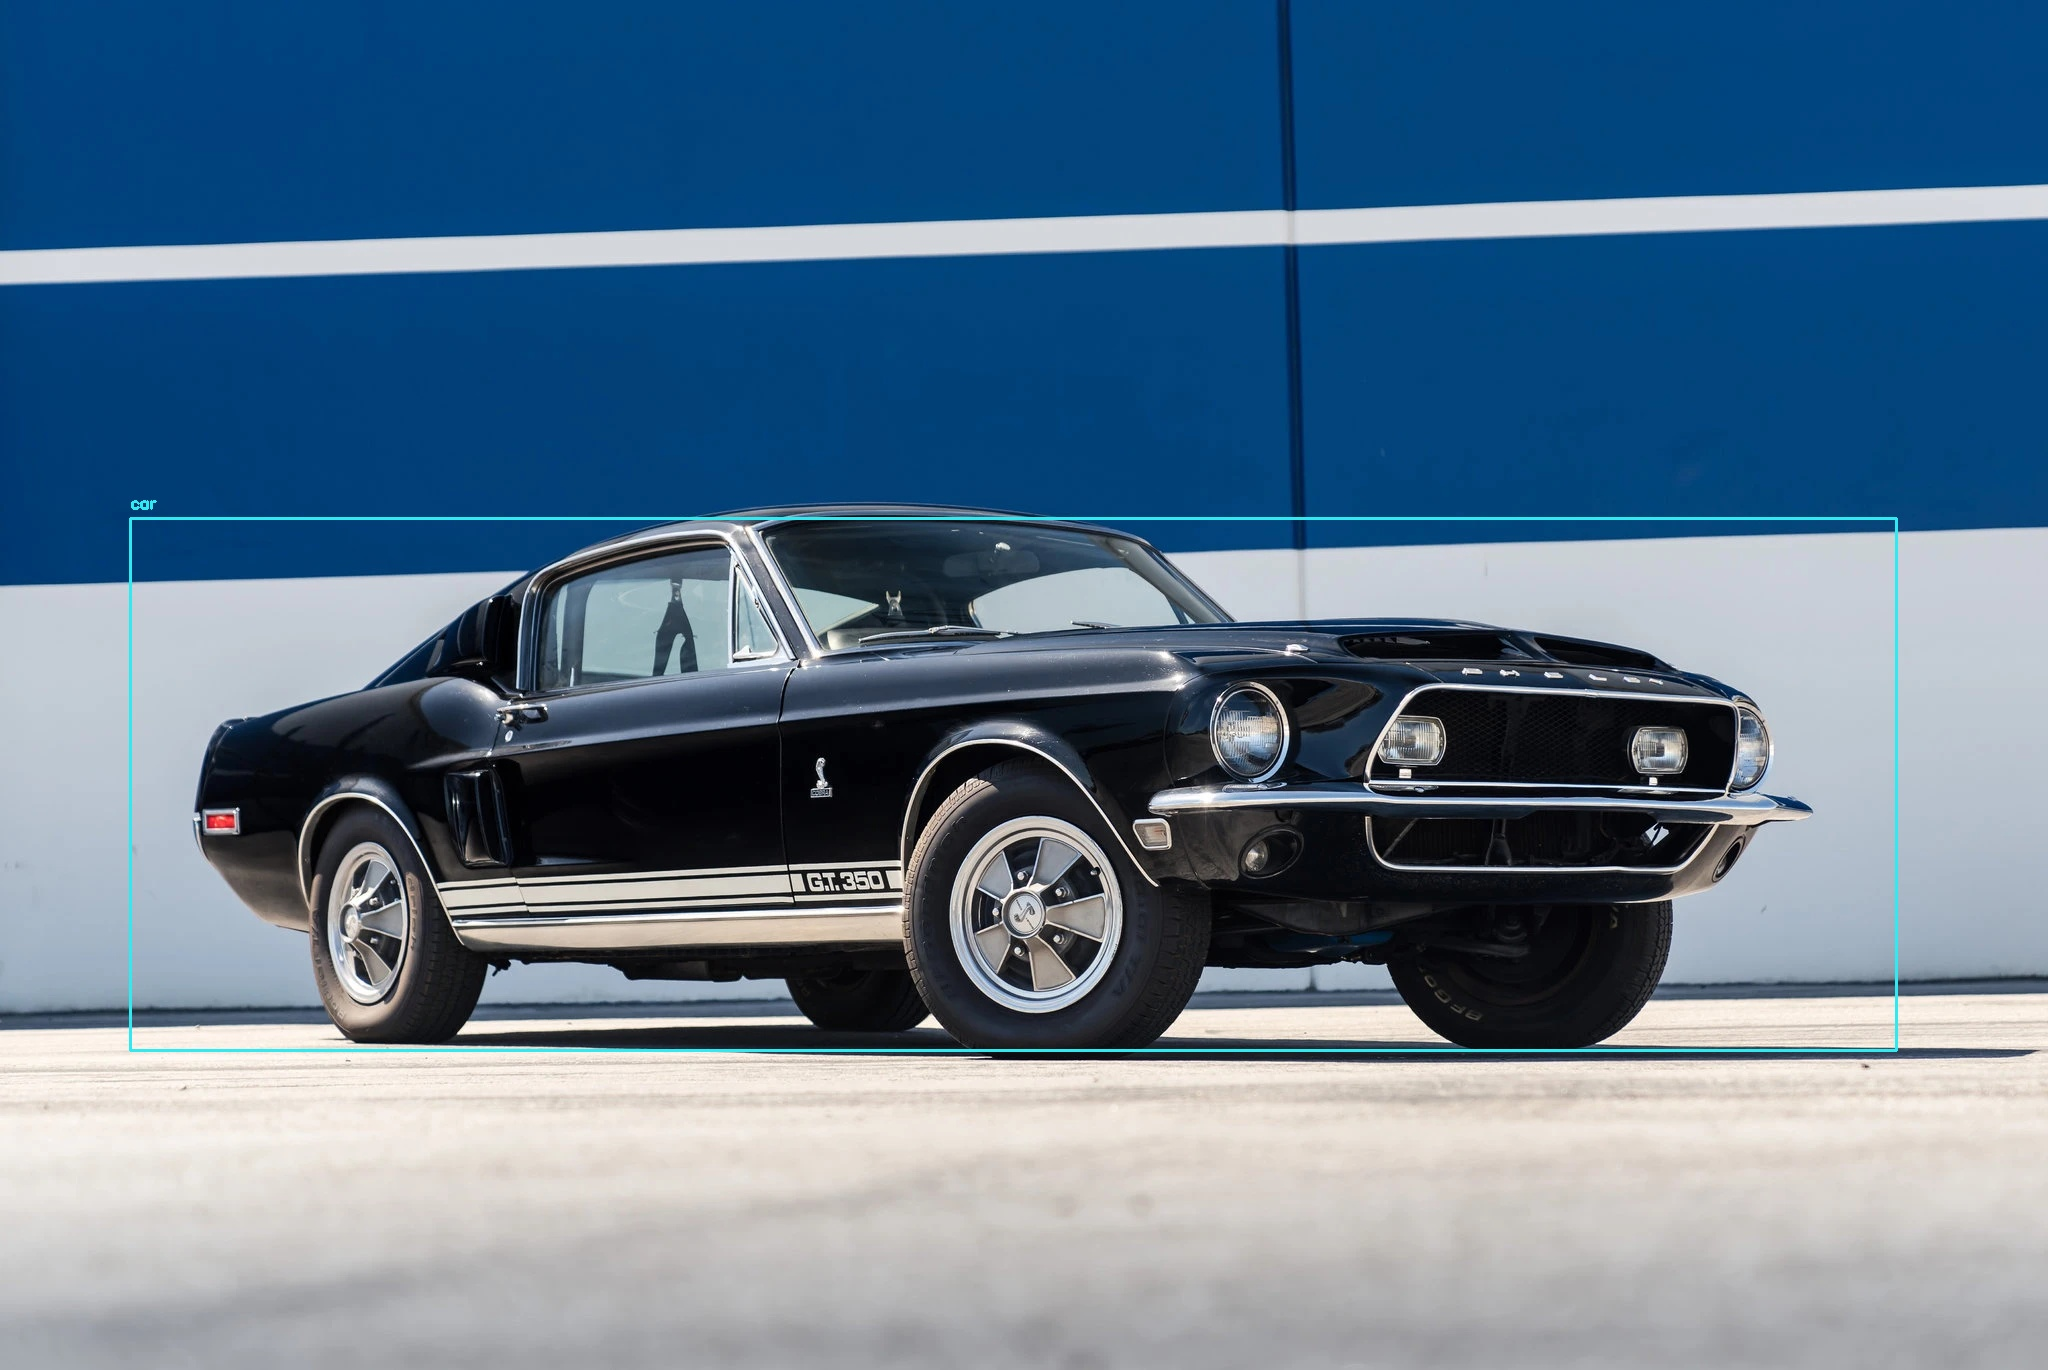

Image processed: rocket.jpg

Detect object: airplane has a confidence level of 0.7199714183807373



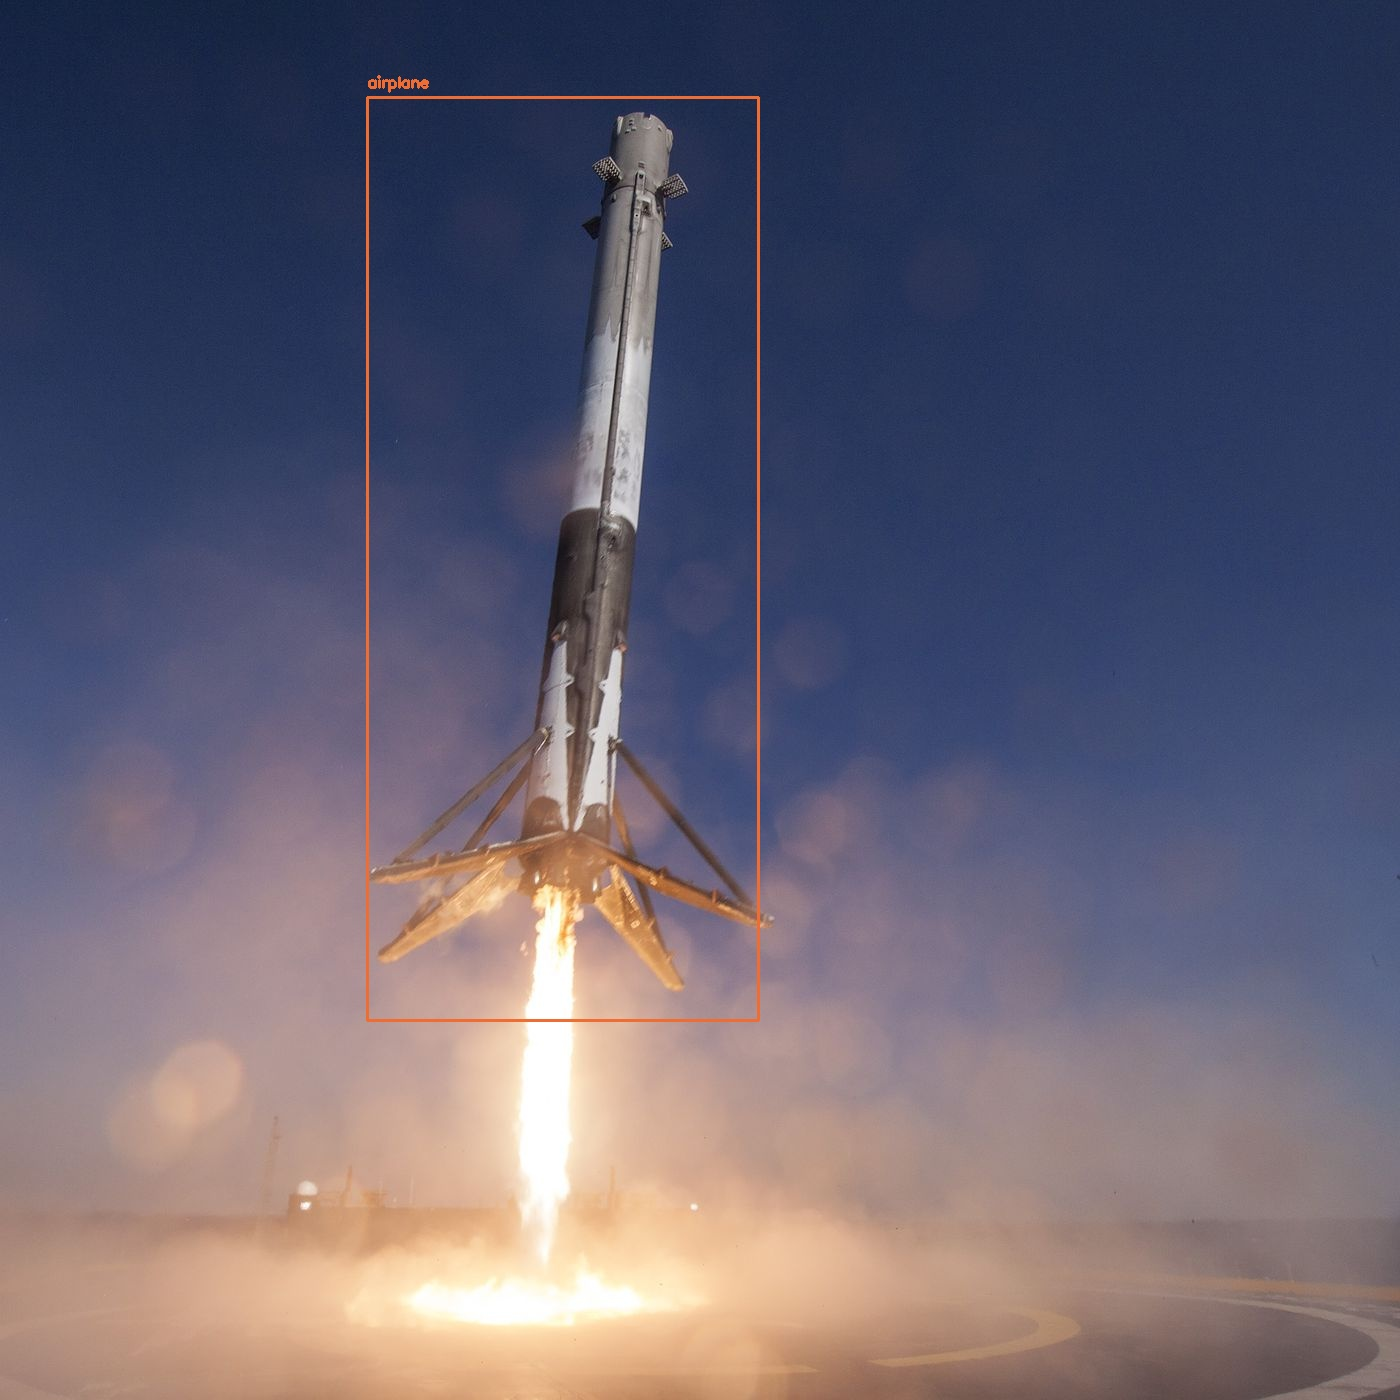

Image processed: steak.jpg

Detect object: knife has a confidence level of 0.9071512818336487

Detect object: cake has a confidence level of 0.5126065015792847



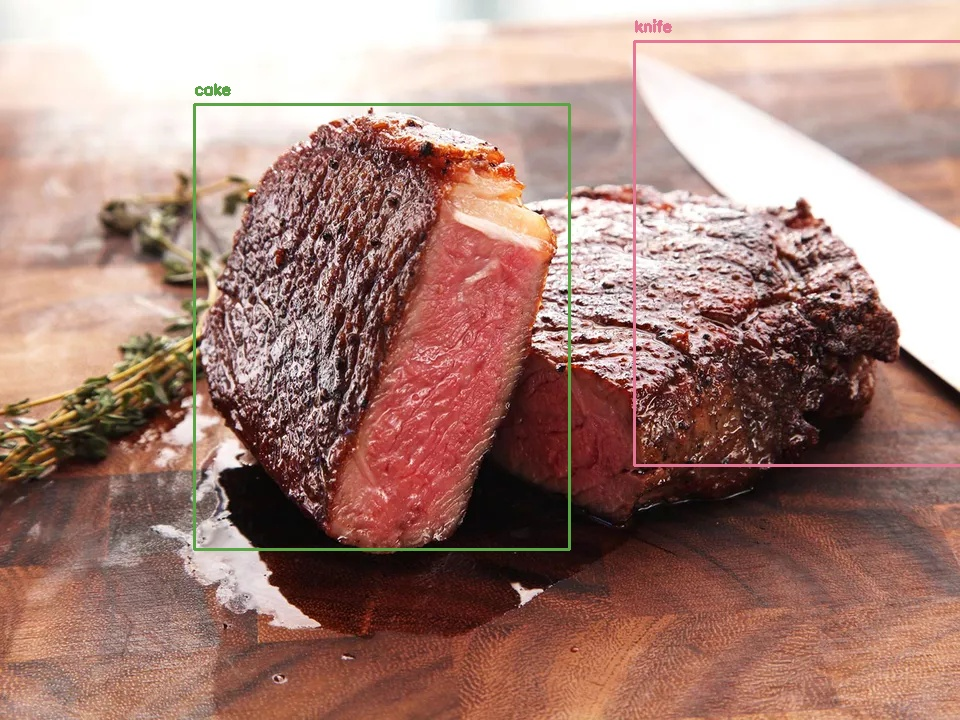

In [6]:
for image in images:
    detect_and_identify(image)

# Confidence level experimentation

Image processed: roses.jpg

Detect object: chair has a confidence level of 0.6949930787086487

Detect object: chair has a confidence level of 0.5436860918998718

Detect object: chair has a confidence level of 0.5072088837623596



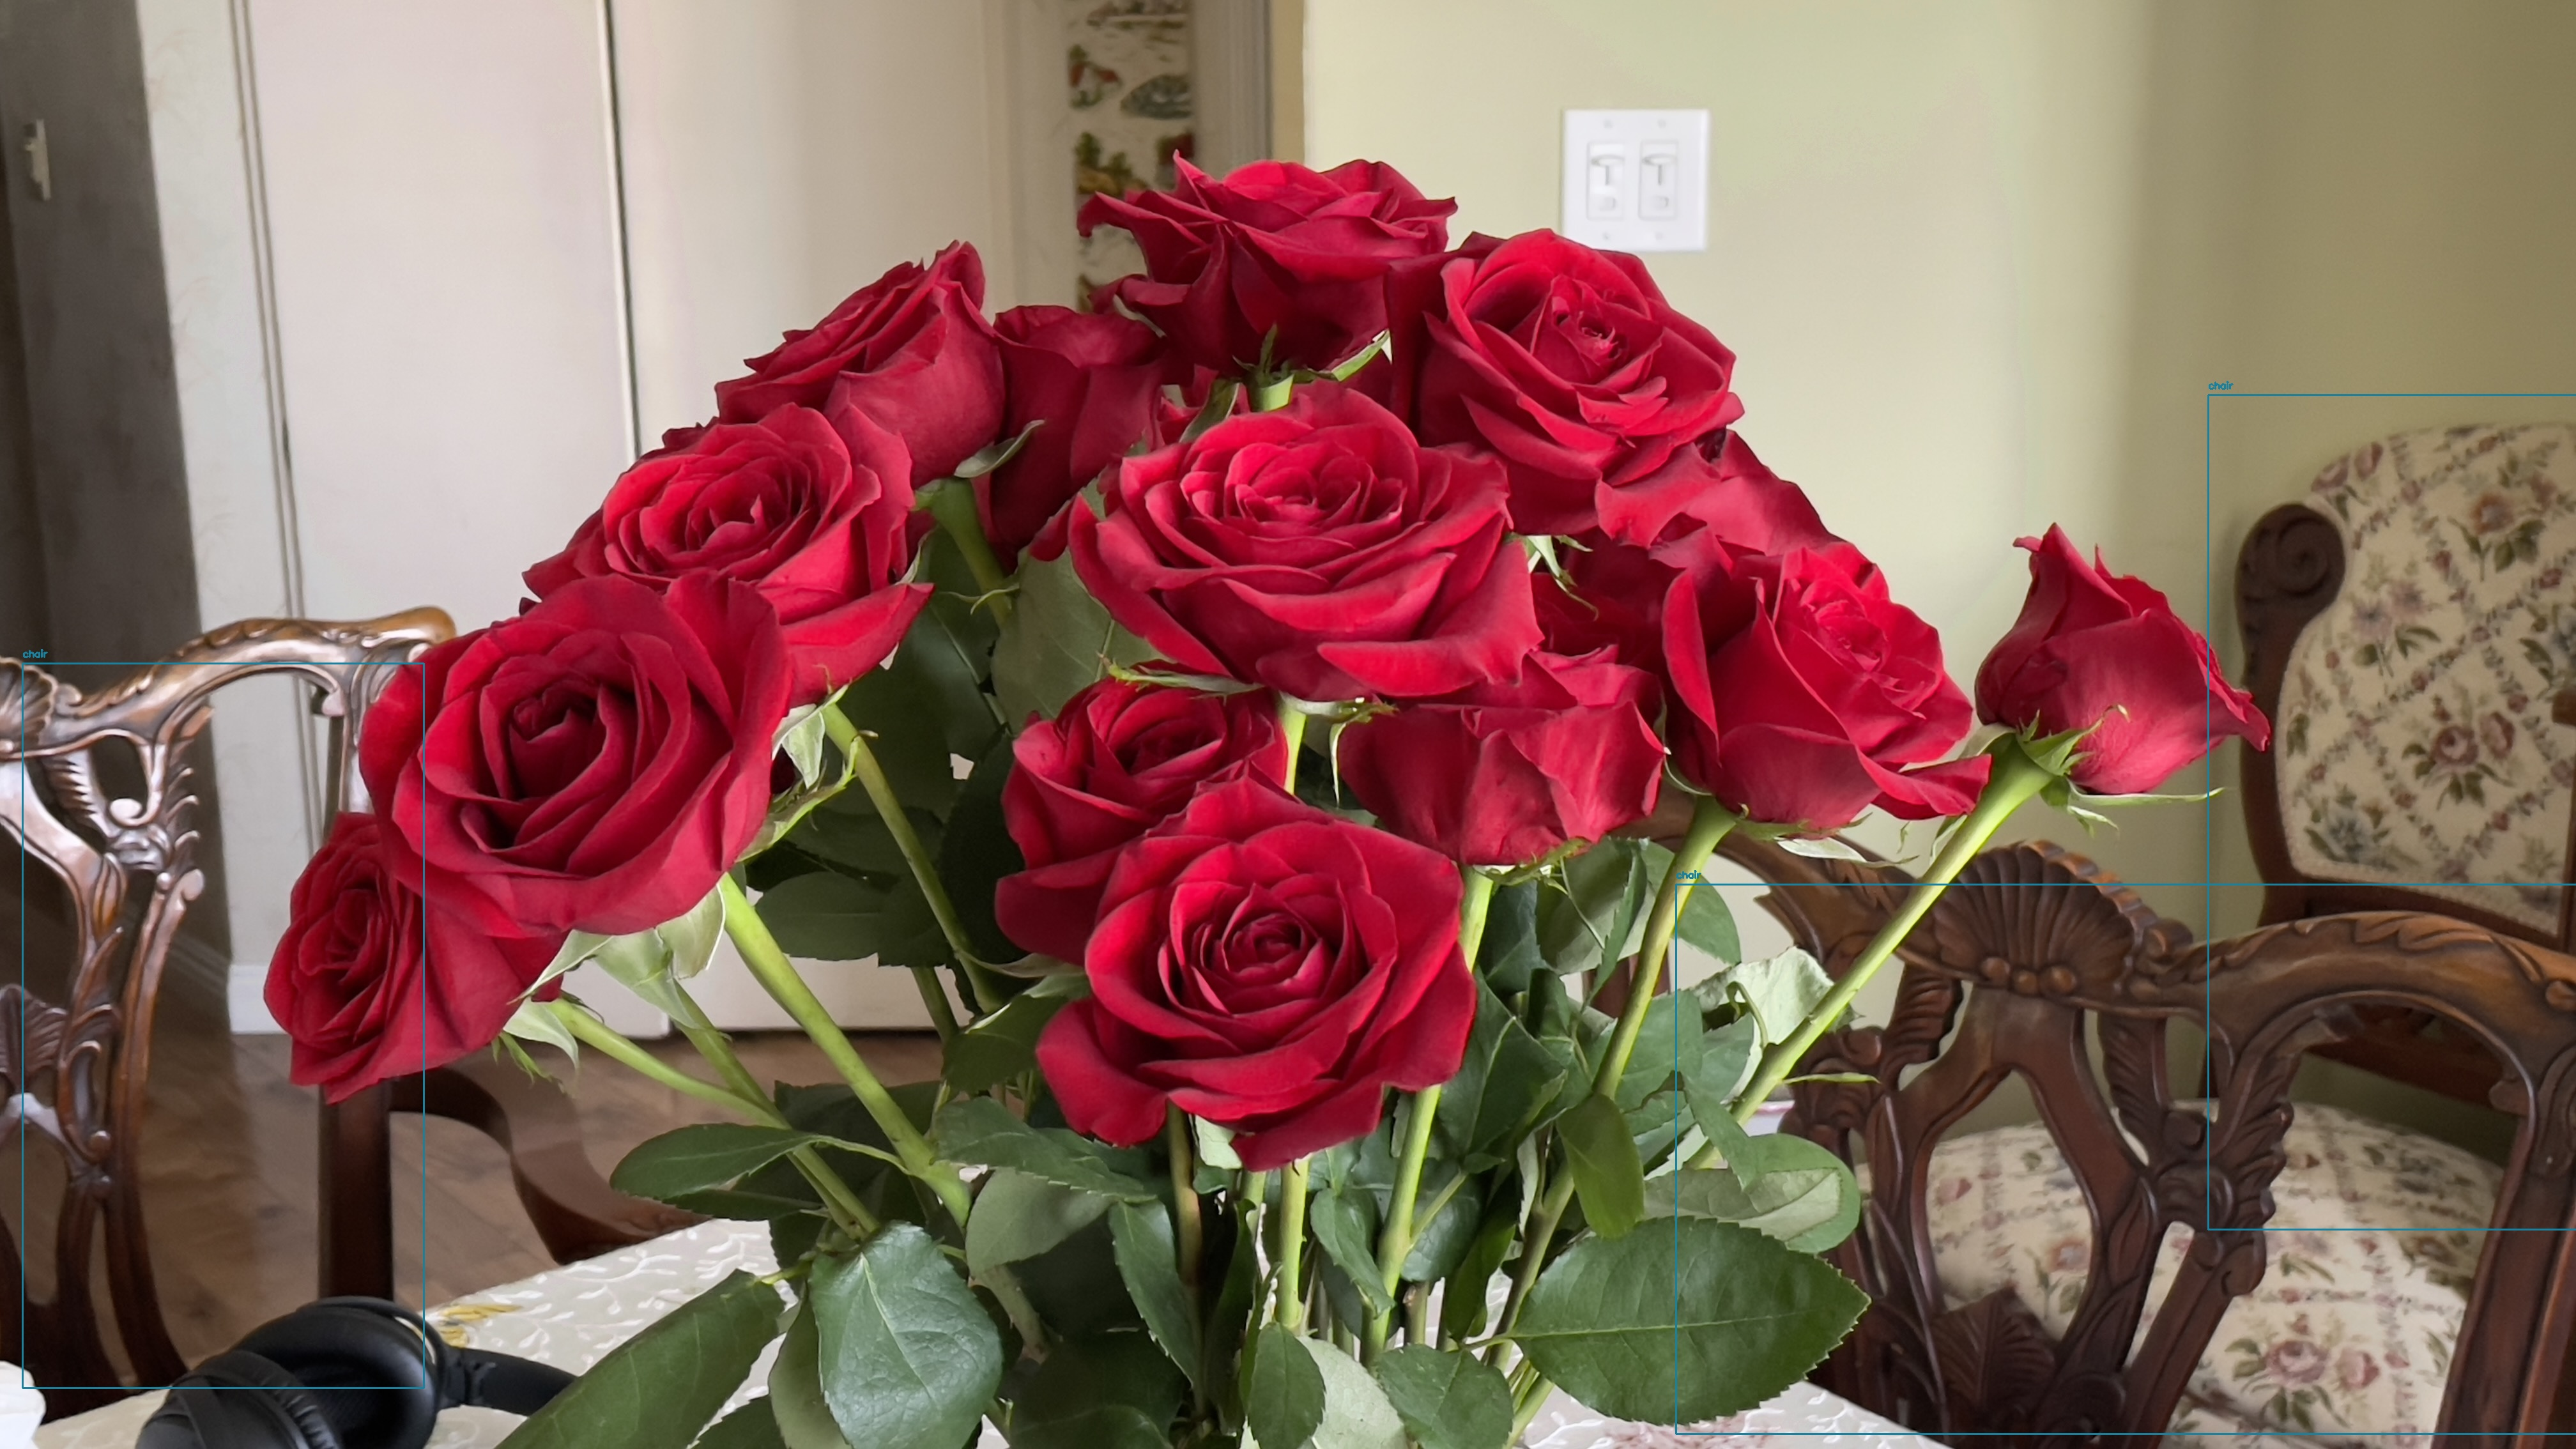

In [7]:
detect_and_identify('roses.jpg', confidence=0.01)

Image processed: steak.jpg

Detect object: knife has a confidence level of 0.9071512818336487

Detect object: cake has a confidence level of 0.5126065015792847



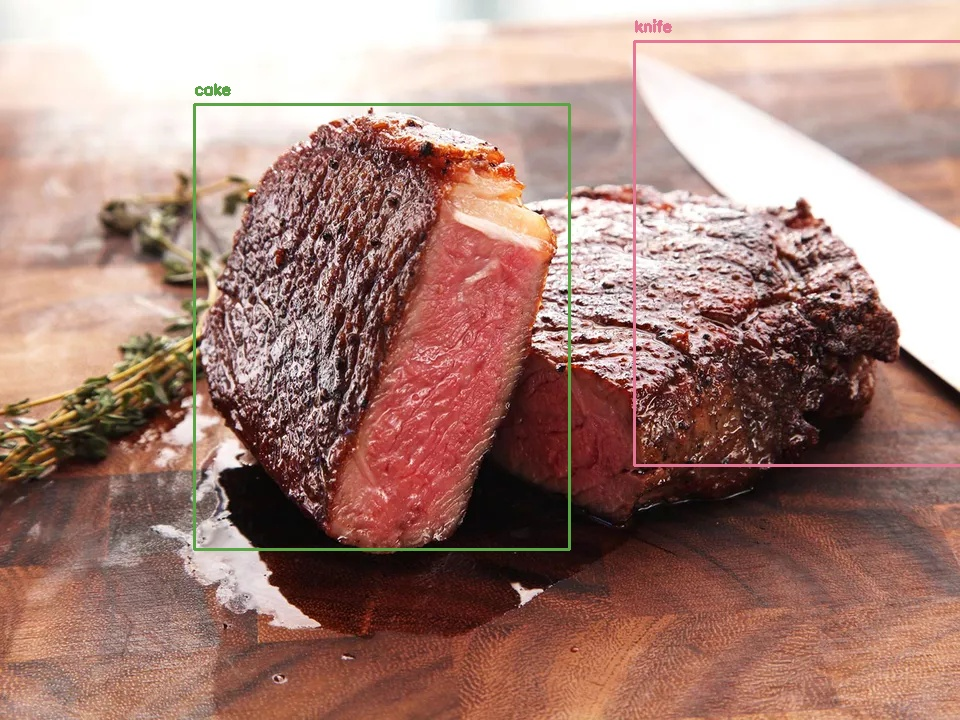

In [8]:
detect_and_identify('steak.jpg', confidence=0.01)

# Deploy model with fastAPI

In [9]:
#Store images in a new directory
uploaded = 'uploaded_images'
if not os.path.exists(uploaded):
    os.mkdir(uploaded)

In [32]:
import numpy as np
import io
import uvicorn
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [30]:
#Create instance for fastAPI
app = FastAPI(title='Deploying Model')

class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"
    vgg19 = 'vgg19'
    

#Use GET method to work for the / endpoint
@app.get("/")
def home():
    return "API is working!"

#Use POST method to upload photo to server and to model
@app.post("/predict")
def prediction(model: Model, file: UploadFile = File(...)):
    
    # 1 Validate input file
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ('jpg', 'jpeg', 'png')
    if not fileExtension:
        raise HTTPException(status_code=415, detail='Unsupported File')
        
    # 2. Transform image into CV2 image
    
    #Read image as stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    #Start stream from begining
    image_stream.seek(0)
    
    #Write stream of bytes into numpy array 
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    #Decode numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # 3 Run Image Classification Model
    
    # Run detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    #Output images
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save to directory within server
    cv2.imwrite(f'processed_images/{filename}', output_image)
    
    # 4. Stream response back to client
    file_image = open(f'processed_images/{filename}', mode='rb')
    
    #Return image as stream 
    return StreamingResponse(file_image, media_type='image/jpeg')

In [31]:
# All the server to be run in a interactive environment
nest_asyncio.apply()

# Setup Host
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Launch server! 
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [19271]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:46692 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:46692 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:46692 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:46694 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:46700 - "POST /predict?model=vgg19 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [19271]
